# Data Preprocessing

## Particle Gun

The dataset is found in [hugging face dataset](https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/unformatted_dataset/ParticleGunDataSet_800k.root)

| particle name | momentum range [GeV] | theta ($\theta$) range [deg] | phi ($\phi$) range [deg] | No Of Events |
| --------------|----------------------|-------------------|-----------------|---------------|
| $\gamma$      |  0.1 - 4.0           |   1 - 11          |     0 - 360     | 500k |
| $\pi^{+}$     |  0.1 - 4.0           |   1 - 11          |     0 - 360     | 250k |
| $\pi^{-}$     |  0.1 - 4.0           |   1 - 10          |     0 - 360     | 250k |


### FCALShowers tree

The `FCALShowers` tree stores reconstructed and truth-level information for individual showers in the Forward Calorimeter (FCAL).  
Each entry corresponds to one shower and includes both *thrown particle kinematics* (from Monte Carlo truth) and *reconstructed shower quantities* derived from detector hits.

| **Variable Name**         | **Type**        | **Shape / Count** | **Description** |
|----------------------------|-----------------|-------------------|-----------------|
| `thrownPID`                | `int32_t`       | Scalar            | Particle ID (PDG code) of the thrown particle generating this shower. |
| `thrownEnergy`             | `double`        | Scalar            | True (thrown) particle energy in GeV. |
| `thrownPosition_fX`        | `double`        | Scalar            | X-coordinate of the thrown particle’s production vertex (cm). |
| `thrownPosition_fY`        | `double`        | Scalar            | Y-coordinate of the thrown particle’s production vertex (cm). |
| `thrownPosition_fZ`        | `double`        | Scalar            | Z-coordinate of the thrown particle’s production vertex (cm). |
| `thrownMomentum_fX`        | `double`        | Scalar            | X-component of the thrown particle momentum (GeV/c). |
| `thrownMomentum_fY`        | `double`        | Scalar            | Y-component of the thrown particle momentum (GeV/c). |
| `thrownMomentum_fZ`        | `double`        | Scalar            | Z-component of the thrown particle momentum (GeV/c). |
| `thrownMass`               | `double`        | Scalar            | True mass of the thrown particle (GeV/c²). |
| `numBlocks`                | `int32_t`       | Scalar            | Number of FCAL blocks (crystals) contributing to this shower. |
| `isNearBorder`             | `bool`          | Scalar            | Flag indicating whether the shower lies close to the calorimeter edge (can affect reconstruction). |
| `showerE`                  | `double`        | Scalar            | Total reconstructed energy of the shower (GeV). |
| `showerPos_fX`             | `double`        | Scalar            | X-position of the reconstructed shower centroid (cm). |
| `showerPos_fY`             | `double`        | Scalar            | Y-position of the reconstructed shower centroid (cm). |
| `showerPos_fZ`             | `double`        | Scalar            | Z-position of the reconstructed shower centroid (cm). |
| `nrows`                    | `int32_t`       | Scalar            | Number of hit entries in the `rows` array. |
| `rows`                     | `int32_t[]`     | Variable-length   | Row indices of FCAL cells contributing to the shower. |
| `ncols`                    | `int32_t`       | Scalar            | Number of hit entries in the `cols` array (same as `nrows`). |
| `cols`                     | `int32_t[]`     | Variable-length   | Column indices of FCAL cells contributing to the shower. |
| `nenergies`                | `int32_t`       | Scalar            | Number of energy values in the `energies` array (same as `nrows`). |
| `energies`                 | `double[]`      | Variable-length   | Energy deposited in each hit cell (GeV). |
| `isSplitOff`               | `bool`          | Scalar            | Flag indicating if this shower is identified as a *split-off* from a nearby hadronic interaction. |
| `isPhotonShower`           | `bool`          | Scalar            | True if the shower is a 'good' photon shower. |

---

### Notes:
- Arrays (`rows`, `cols`, `energies`) contain per-hit information for the FCAL blocks belonging to that shower.
- Energy ratios (`E1E9`) -- The central crystal to surrounding 3×3 block (used to identify EM vs hadronic showers).
- Energy ratio (`E9E25`) -- The 3×3 vs 5×5 crystal windows around the shower maximum (shower compactness measure)
- The boolean flags (`isSplitOff`, `isPhotonShower`) are used to build labeled datasets for classification tasks such as photon identification.
- `thrown*` quantities provide the Monte Carlo truth-level reference for evaluating reconstruction performance and training regression models.






In [23]:
%pip install uproot awkward-pandas pandas matplotlib seaborn vector tqdm plotly > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [25]:
import os
from urllib.parse import urlparse
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    """Custom TQDM progress bar for urllib downloads."""
    def update_to(self, blocks=1, block_size=1, total_size=None):
        """
        Update the progress bar.

        Args:
            blocks (int): Number of blocks transferred so far.
            block_size (int): Size of each block (in bytes).
            total_size (int, optional): Total size of the file (in bytes).
        """
        if total_size is not None:
            self.total = total_size
        self.update(blocks * block_size - self.n)


def download(url, target_dir):
    """
    Download a file from a URL into the target directory with progress display.

    Args:
        url (str): Direct URL to the file.
        target_dir (str): Directory to save the file.

    Returns:
        str: Path to the downloaded (or existing) file.
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Infer the filename from the URL
    filename = os.path.basename(urlparse(url).path)
    local_path = os.path.join(target_dir, filename)

    # If file already exists, skip download
    if os.path.exists(local_path):
        print(f"✅ File already exists: {local_path}")
        return local_path

    # Download with progress bar
    print(f"⬇️  Downloading {filename} from {url}")

    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
        urllib.request.urlretrieve(url, filename=local_path, reporthook=t.update_to)

    print(f"✅ Download complete: {local_path}")
    return local_path

data_dir = "data"

In [27]:
unformatted_particle_data_url = "https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/unformatted_dataset/ParticleGunDataSet_800k.root"

dataset_path = download(unformatted_particle_data_url, data_dir)


⬇️  Downloading ParticleGunDataSet_800k.root from https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/unformatted_dataset/ParticleGunDataSet_800k.root


ParticleGunDataSet_800k.root: 102MB [00:01, 95.2MB/s]                            

✅ Download complete: data/ParticleGunDataSet_800k.root


In [10]:
# Lets look into the ALLFCALHits tree of the files,
import uproot, pandas as pd, matplotlib.pyplot as plt
import numpy as np

dataset_tree = uproot.open(dataset_path)["FCALShowers"]

for branch in dataset_tree.branches:
    print (f"{branch.name} of type {branch.typename}")



index of type int64_t
thrownPID of type int32_t
thrownEnergy of type double
thrownPosition_fX of type double
thrownPosition_fY of type double
thrownPosition_fZ of type double
thrownMomentum_fX of type double
thrownMomentum_fY of type double
thrownMomentum_fZ of type double
thrownMass of type double
numBlocks of type int32_t
isNearBorder of type bool
showerE of type double
showerPos_fX of type double
showerPos_fY of type double
showerPos_fZ of type double
nrows of type int32_t
rows of type int64_t[]
ncols of type int32_t
cols of type int64_t[]
nenergies of type int32_t
energies of type double[]
isSplitOff of type bool
isPhotonShower of type bool


In [11]:
df = dataset_tree.arrays(library="pd")

print (f"DataFrame shape: {df.shape}")


DataFrame shape: (814151, 24)


Number of photon showers: 434845
Number of split-off showers: 379306


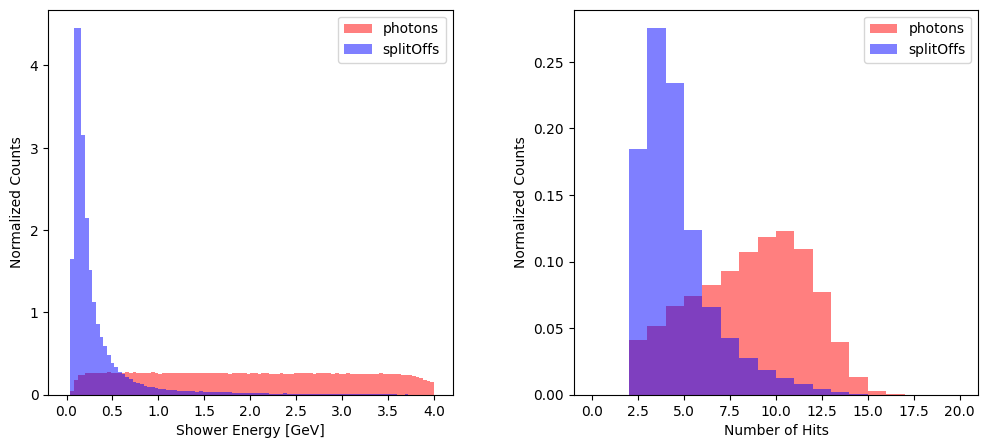

In [16]:
## Lets look into some of the distributions 

photon_df = df[df['isPhotonShower'] == 1]
splitOffs_df = df[df['isSplitOff'] == 1]

print (f"Number of photon showers: {photon_df.shape[0]}")
print (f"Number of split-off showers: {splitOffs_df.shape[0]}")

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5), gridspec_kw={"hspace": 0.45, "wspace": 0.30})
ax = axs[0]
ax.hist(photon_df["showerE"], bins = 100, range = (0., 4.0), label = "photons", alpha = 0.5, density = True, color = "red")
ax.hist(splitOffs_df["showerE"], bins = 100, range = (0., 4.0), label = "splitOffs", alpha = 0.5, density = True, color = "blue")
ax.set_xlabel("Shower Energy [GeV]")
ax.set_ylabel("Normalized Counts")
ax.legend()

ax = axs[1]
ax.hist(photon_df["nrows"], bins = 20, range = (0, 20), label = "photons", alpha = 0.5, density = True, color = "red")
ax.hist(splitOffs_df["nrows"], bins = 20, range = (0, 20), label = "splitOffs", alpha = 0.5, density = True, color = "blue")
ax.set_xlabel("Number of Hits")
ax.set_ylabel("Normalized Counts")
ax.legend()

plt.show()                                                      

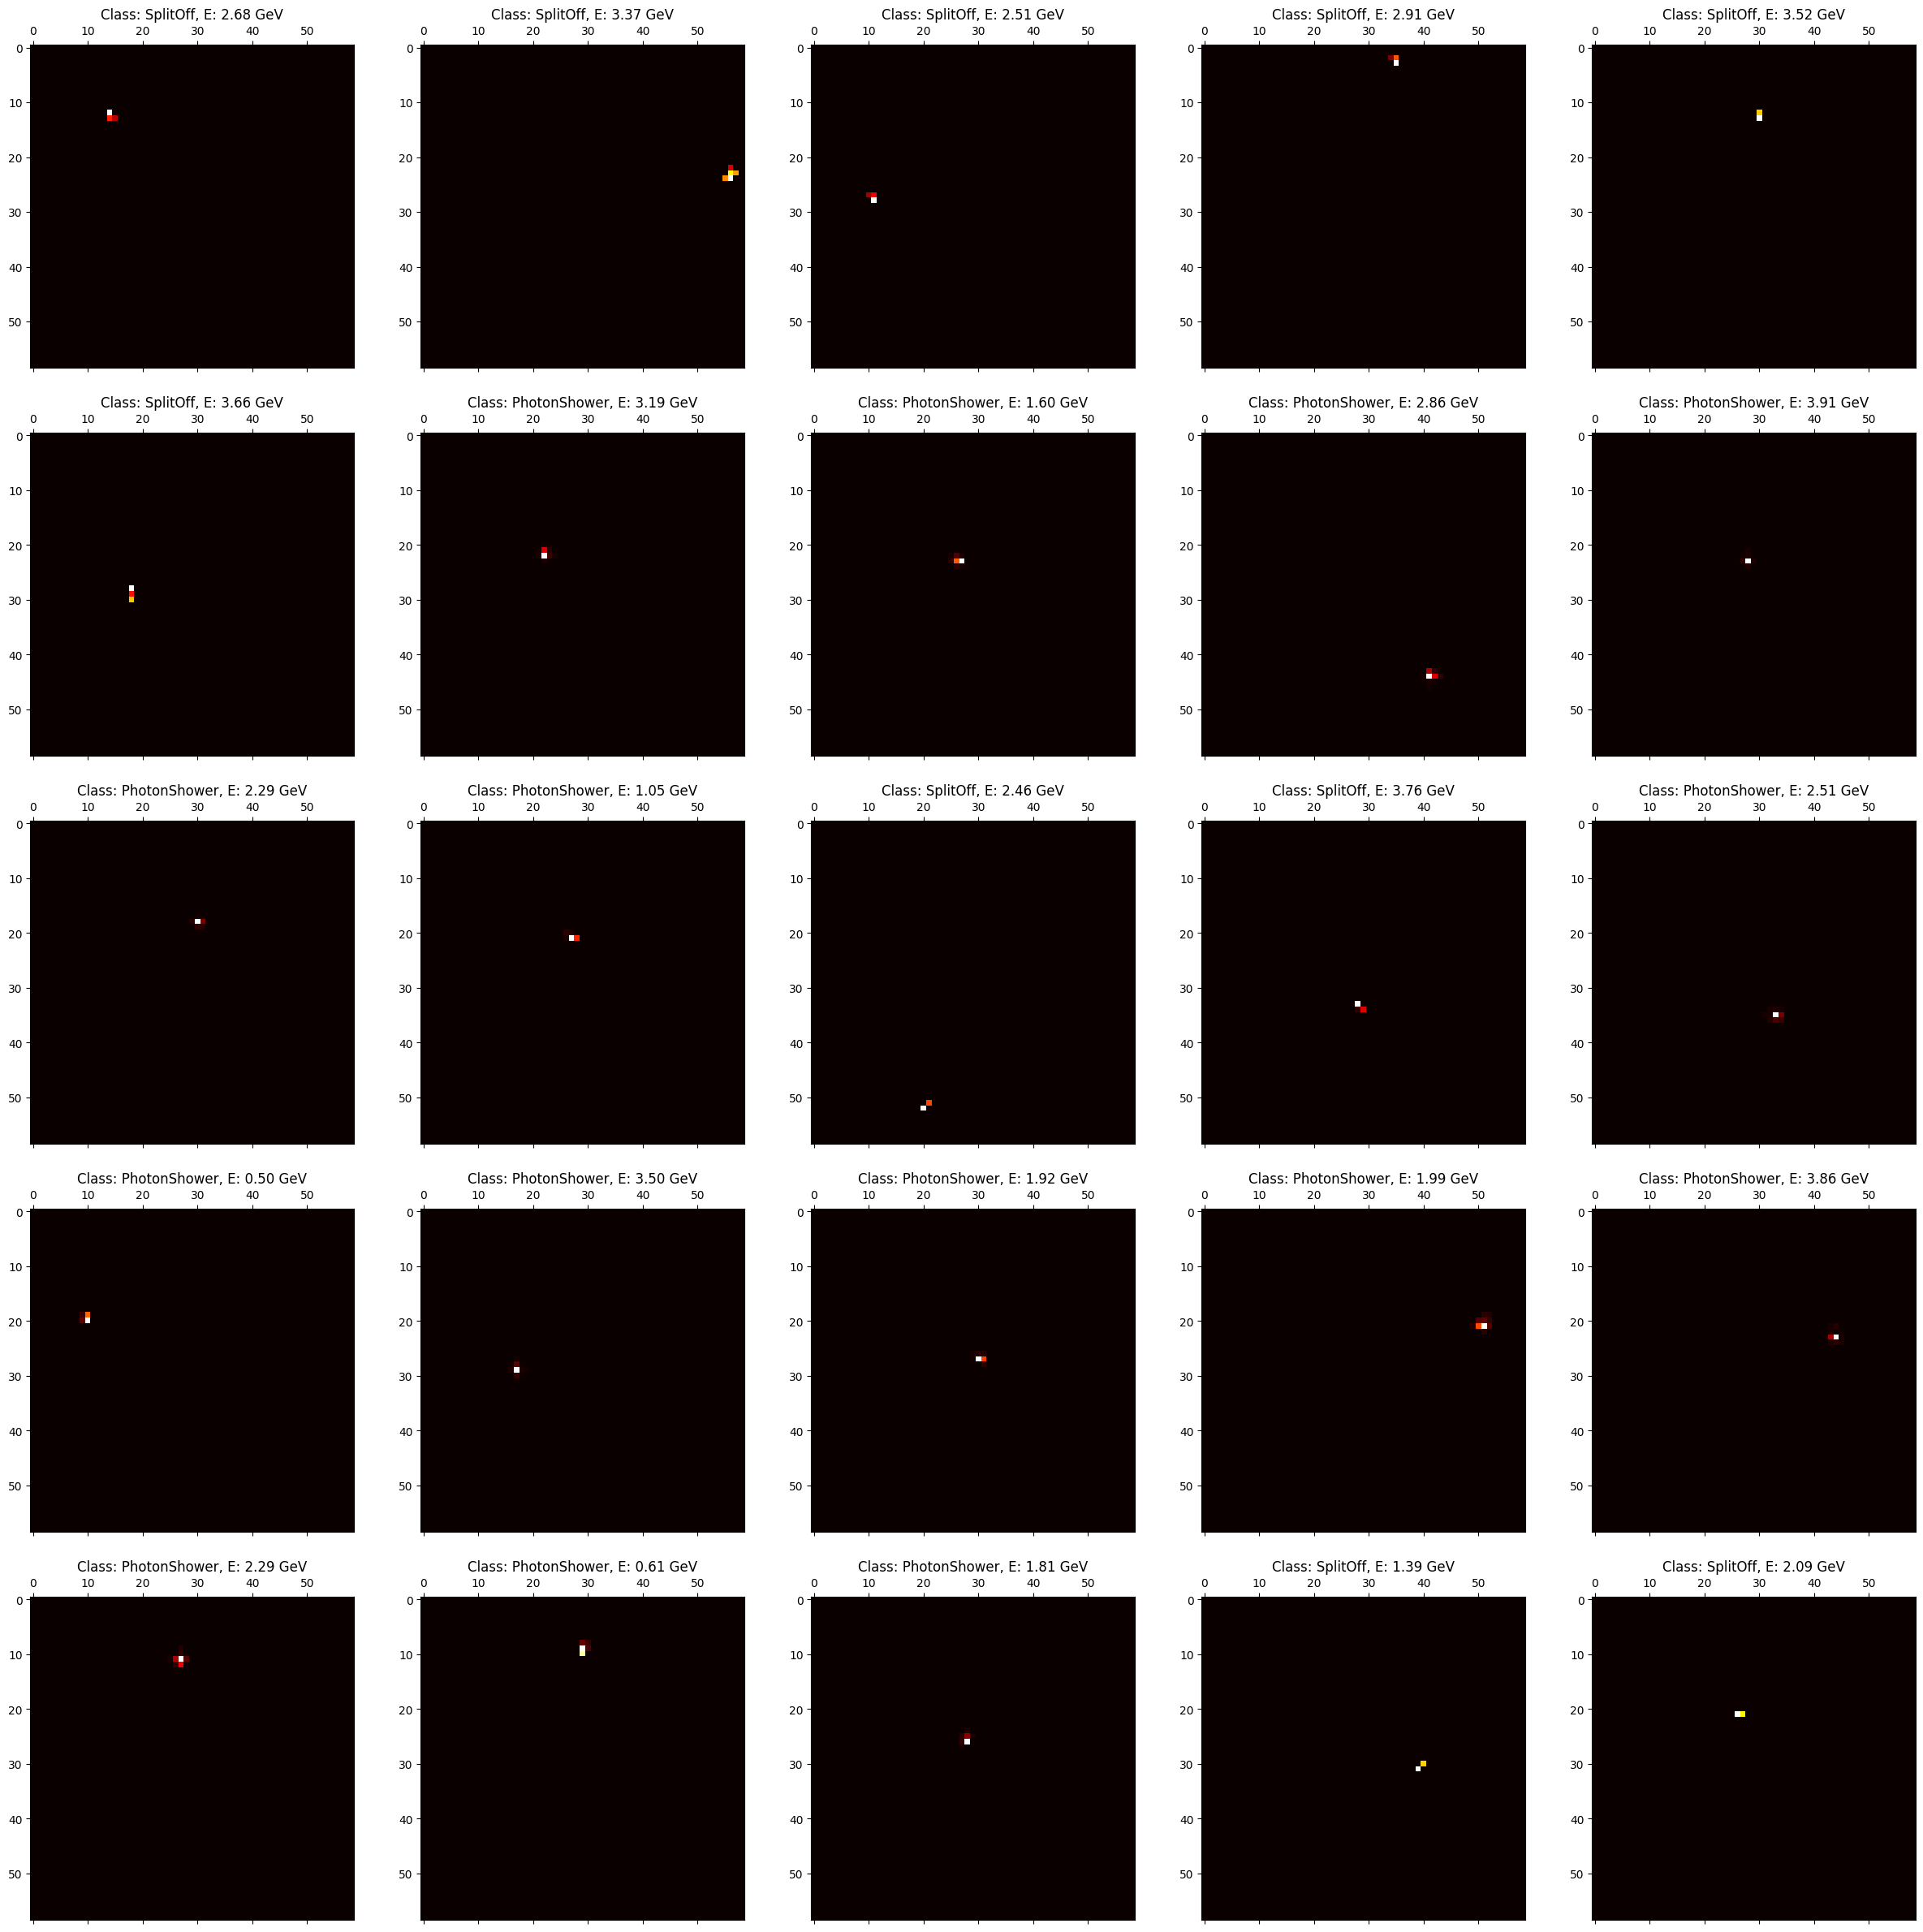

In [ ]:
# Lets make a HitMap of all the hits.

FCAL_GEOMETRY = (59, 59)

def MakeHitMap(evnt, min_hits = 1):
  if len(evnt.rows) < min_hits: return None
  matrix_energies = np.zeros(FCAL_GEOMETRY)
  matrix_energies[evnt.rows, evnt.cols] = evnt.energies
  return matrix_energies

# Lets draw a few images side by side
titles = ["isPhotonShower", "isSplitOff"]
NROWS = 5
NCOLS = 5
fig, axs = plt.subplots(nrows = NROWS, ncols = NCOLS, figsize = (30, 30))

for r in range(NROWS):
  for c in range(NCOLS):
    evt = df.iloc[r * NCOLS + c]
    hitmap = MakeHitMap(evt)
    if hitmap is None: continue
    axs[r, c].matshow(hitmap, cmap='hot')

    title = ""
    if evt.isPhotonShower:
      title += "PhotonShower"
    else:
      title += "SplitOff"
    axs[r, c].set_title(f"Class: {title}, E: {df.iloc[r * NCOLS + c].showerE:.2f} GeV")
plt.show()


### Sparse Nature of FCAL Shower Images and Motivation for Preprocessing

As can be observed from the raw FCAL shower images, the spatial energy deposition is **highly sparse**.  
Each shower typically consists of only a small number of active cells (often less than ten) within the full calorimeter readout grid (e.g., 59×59). This means that the majority of pixels in these images carry zero or negligible energy, leading to two significant challenges:

1. **Computational Inefficiency** —  
   Large image dimensions dominated by empty pixels increase memory usage and slow down both training and inference without adding useful information.

2. **Learning Difficulty** —  
   Deep neural networks, particularly convolutional models, rely on spatially distributed correlations in the data. When most of the input space is inactive, learning meaningful spatial patterns becomes statistically inefficient and often requires excessive regularization or larger datasets to generalize well.

To address these challenges, we apply a **preprocessing step** that reduces the spatial extent of each shower image while preserving its physically relevant structure. Specifically, we extract a **localized patch** centered on the maximum-energy cell (the shower core). This region captures the essential shower morphology — including the energy spread and asymmetry — while discarding irrelevant empty space.

We define this reduced image dimension as `PATCH_SIZE`.  
For example, a `PATCH_SIZE = 11` corresponds to an 11×11 grid centered on the highest-energy crystal of the shower. This compact representation provides a balance between preserving spatial resolution and improving learning efficiency.

Because this preprocessing must be applied consistently across all showers, it is implemented programmatically through a vectorized procedure. This ensures uniformity in how patches are extracted and guarantees that each patch remains aligned with its physical shower center.


## Patch Construction and Dataset Preparation

In this section, lets see how we can construct the *localized energy patches* from the Forward Calorimeter (FCAL) hit data and organize them into an HDF5 dataset suitable for training machine-learning models.

Each FCAL shower consists of a collection of calorimeter cell hits, each hit defined by its grid coordinates `(row, col)` and deposited energy. The goal is to convert these irregular hit patterns into fixed-size **11×11 image patches** centered on the highest-energy cell in each shower. These patches serve as compact spatial representations of shower shapes that can be directly used as CNN inputs.

---

### 1. Building 11×11 Energy Patches

The function `make_patches_vectorized()` takes as input the lists of hit rows, columns, and energies for each shower and performs the following steps:

1. **Padding and Masking**  
   - Because each shower has a variable number of hits, we first pad all showers to the same maximum length using zero-filled arrays.  
   - We also build a boolean `mask` array to keep track of which elements are real hits and which are padding.

2. **Finding the Shower Center**  
   - For each shower, the cell with the maximum deposited energy is identified.  
   - The `(row, col)` of this maximum-energy cell is taken as the **center** of the 11×11 patch.

3. **Computing Relative Coordinates**  
   - Each hit’s position is shifted relative to the center so that the central cell maps to `(5, 5)` in the 11×11 window (since `patch_size = 11` and `half = 5`).

4. **Selecting Valid Hits**  
   - Hits that fall outside the 11×11 window boundaries are discarded.  
   - The remaining hits are “valid” and will contribute energy to the patch.

5. **Filling the Patch**  
   - Using NumPy’s `np.add.at()` (which supports indexed accumulation), each valid hit’s energy is added to its corresponding pixel location `(r, c)` within the 11×11 array for that shower.

6. **Returning the Patch Array**  
   - The output is an array of shape `(N, 11, 11)` where `N` is the number of showers.  
   - Each entry is an image-like representation of an FCAL shower’s energy deposition pattern.



In [19]:
import numpy as np

def make_patches_vectorized(rows_list, cols_list, energies_list, patch_size=11):
    n_showers = len(rows_list)
    max_hits = max(len(r) for r in rows_list)
    half = patch_size // 2

    # Pad all to same length
    rows = np.zeros((n_showers, max_hits), dtype=np.int32)
    cols = np.zeros((n_showers, max_hits), dtype=np.int32)
    energies = np.zeros((n_showers, max_hits), dtype=np.float32)
    mask = np.zeros((n_showers, max_hits), dtype=bool)

    for i, (r, c, e) in enumerate(zip(rows_list, cols_list, energies_list)):
        n = len(r)
        rows[i, :n] = r
        cols[i, :n] = c
        energies[i, :n] = e
        mask[i, :n] = True

    # Find center of each shower (max energy cell)
    idx_max = np.argmax(energies, axis=1)
    centers_r = rows[np.arange(n_showers), idx_max]
    centers_c = cols[np.arange(n_showers), idx_max]

    # Compute relative coordinates for all hits
    rel_r = rows - centers_r[:, None] + half
    rel_c = cols - centers_c[:, None] + half

    # Keep only hits that fall within the 11x11 window
    valid = (
        mask
        & (rel_r >= 0)
        & (rel_r < patch_size)
        & (rel_c >= 0)
        & (rel_c < patch_size)
    )

    # Now build all patches (vectorized accumulation)
    patches = np.zeros((n_showers, patch_size, patch_size), dtype=np.float32)
    # Flatten for easy advanced indexing
    shower_idx, hit_idx = np.nonzero(valid)
    rr = rel_r[shower_idx, hit_idx]
    cc = rel_c[shower_idx, hit_idx]
    ee = energies[shower_idx, hit_idx]

    np.add.at(patches, (shower_idx, rr, cc), ee)

    return patches


In [30]:
patches = make_patches_vectorized(
    rows_list=df["rows"],
    cols_list=df["cols"],
    energies_list=df["energies"]
)

print(patches.shape)
# -> (nShowers, 11, 11)

df['patches'] = list(patches)

(814151, 11, 11)


### Creating Labels

Each shower in the dataset is labeled according to its origin:

* **1** -- Photon Shower (true electromagnetic)
* **0** -- Split-off Shower (hadronic secondary)
* **-1** -- Others or undefined (This should never happen in this case)

In [32]:
import numpy as np

df["labels"] = np.where(df["isPhotonShower"], 1,
                       np.where(df["isSplitOff"], 0, -1))


In [35]:
print(df[["isPhotonShower", "isSplitOff", "labels"]].tail(10))


        isPhotonShower  isSplitOff  labels
814141            True       False       1
814142            True       False       1
814143            True       False       1
814144            True       False       1
814145            True       False       1
814146           False        True       0
814147           False        True       0
814148            True       False       1
814149           False        True       0
814150            True       False       1


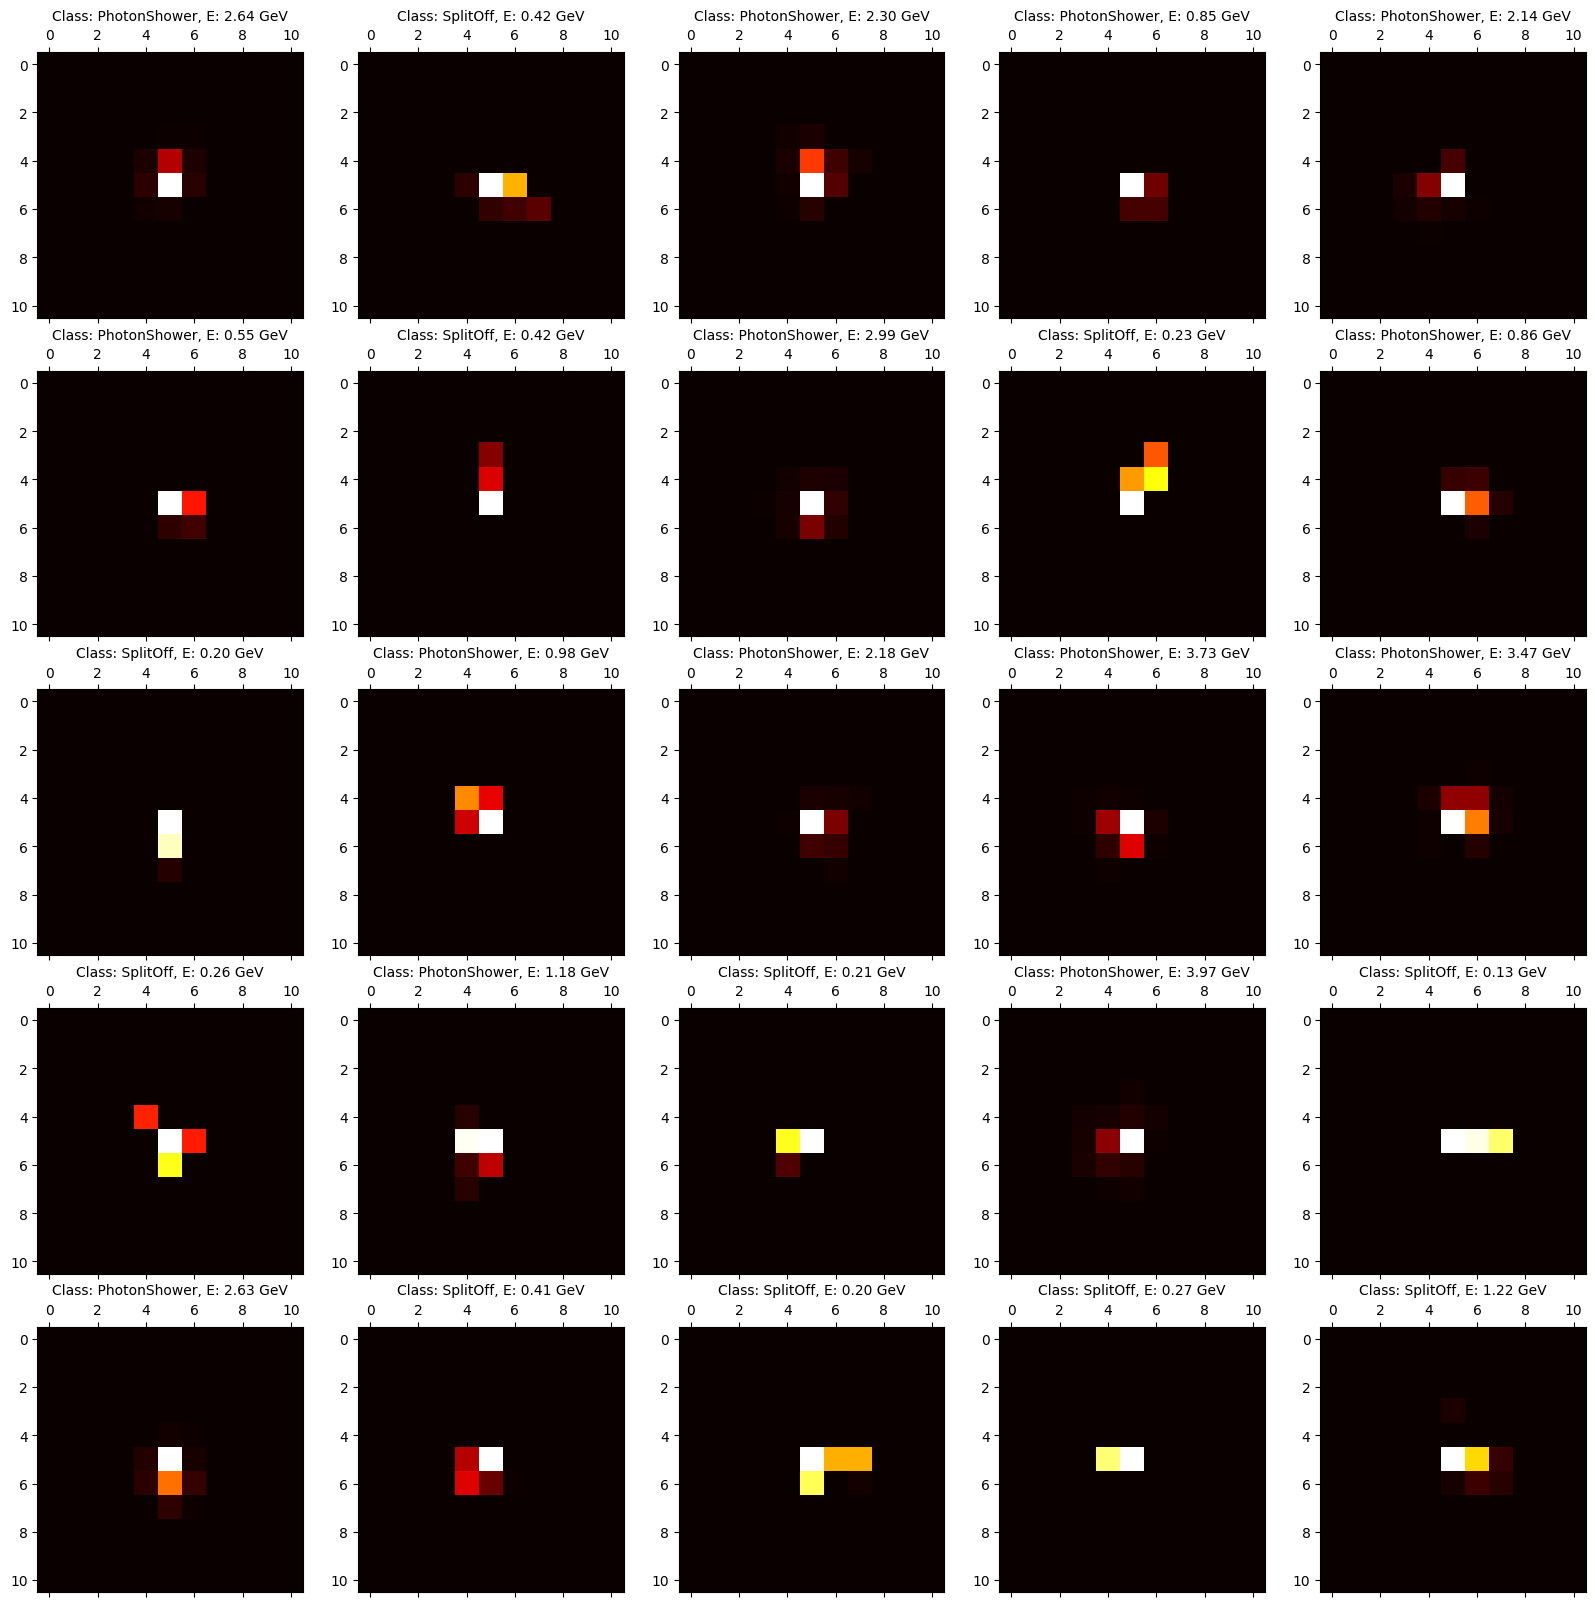

In [53]:
fig, axs = plt.subplots(nrows = 5, ncols = 5, figsize = (20, 20))
# lets pick random 25 showers
indices = np.random.randint(0, df.shape[0], size = 25)
titleDict = {0: "SplitOff", 1: "PhotonShower"}
for i, ax in enumerate(axs.flatten()):
  idx = indices[i]
  ax.matshow(patches[idx], cmap='hot')
  title = titleDict[df.labels.iloc[idx]]
  ax.set_title(f"Class: {title}, E: {df.showerE.iloc[idx]:.2f} GeV", fontsize = 10)
plt.show()

Now, we can save the images as a `.h5` file. 

In [57]:
import h5py
import numpy as np

# Assume these already exist:
# patches: shape (N, 11, 11)
# labels:  shape (N,)          -> e.g., 0 for photon, 1 for splitOff
# showerE: shape (N,)
# thrownE: shape (N,)

output_path = "CNN4FCAL_PATCHSIZE_11.h5"

with h5py.File(output_path, "w") as f:
    # Create datasets
    f.create_dataset("patches", data=patches, compression="gzip", compression_opts=9)
    f.create_dataset("label", data=df["labels"].astype(np.int8))
    f.create_dataset("showerE", data=df["showerE"].astype(np.float32))
    f.create_dataset("thrownE", data=df["thrownEnergy"].astype(np.float32))

    # Add some metadata
    f.attrs["description"] = "GlueX FCAL 11x11 patches centered on max-energy cell"
    f.attrs["label_mapping"] = "{0: splitOff, 1: photon}"
    f.attrs["patch_shape"] = patches.shape[1:]

print(f"✅ Saved dataset with {len(patches)} entries to {output_path}")


✅ Saved dataset with 814151 entries to CNN4FCAL_PATCHSIZE_11.h5


## Omega Events

This Dataset contains Monte Carlo and reconstructed information for exclusive $\omega$ (omega) production events in the GlueX detector.  
The data are stored in the tree **`OmegaSampleTree`**, which organizes both *truth-level (thrown)* and *reconstructed* particle kinematics, as well as calorimeter-level information from the Forward Calorimeter (FCAL).

The dataset is designed to support studies of photon reconstruction, FCAL shower modeling, and the development of fast simulation and machine learning pipelines.

---

### Structure of the `OmegaSampleTree`

| **Variable Name**               | **Type**                          | **Shape / Count**       | **Description** |
|----------------------------------|-----------------------------------|--------------------------|-----------------|
| **thrownPiPlus**                 | `TLorentzVector`                 | Scalar                  | True (Monte Carlo) four-momentum of the generated π⁺ in the ω → π⁺π⁻π⁰ decay. |
| **thrownPiMinus**                | `TLorentzVector`                 | Scalar                  | True four-momentum of the generated π⁻. |
| **thrownRecoilProton**           | `TLorentzVector`                 | Scalar                  | True four-momentum of the recoil proton. |
| **thrownPi0**                    | `TLorentzVector`                 | Scalar                  | True four-momentum of the neutral pion (π⁰) from ω decay. |
| **reconPiPlus**                  | `TLorentzVector`                 | Scalar                  | Reconstructed four-momentum of the π⁺ track, based on detector tracking and kinematic fit. |
| **reconPiMinus**                 | `TLorentzVector`                 | Scalar                  | Reconstructed four-momentum of the π⁻ track. |
| **reconRecoilProton**            | `TLorentzVector`                 | Scalar                  | Reconstructed four-momentum of the recoil proton. |
| **thrownBeam**                   | `TLorentzVector`                 | Scalar                  | Four-momentum of the incident beam photon (used in MC generation). |
| **thrownOmegaMass**              | `double`                         | Scalar                  | True invariant mass of the ω meson (from generated kinematics). |
| **rows**                         | `std::vector<int32_t>`           | Variable-length          | Row indices of FCAL cells contributing to all neutral showers in the event. |
| **cols**                         | `std::vector<int32_t>`           | Variable-length          | Column indices of FCAL cells corresponding to the same hits as `rows`. |
| **energies**                     | `std::vector<double>`            | Variable-length          | Energy deposits (in GeV) for each FCAL hit cell. |
| **times**                        | `std::vector<double>`            | Variable-length          | Time (in ns) of each FCAL hit. |
| **nShowers**                     | `int32_t`                        | Scalar                  | Number of reconstructed neutral showers in the FCAL for this event. |
| **showerT**                      | `std::vector<double>`            | Length = `nShowers`      | Reconstructed timing of each neutral shower. |
| **numBlocks**                    | `std::vector<int32_t>`           | Length = `nShowers`      | Number of calorimeter blocks contributing to each shower. |
| **showerE**                      | `std::vector<double>`            | Length = `nShowers`      | Reconstructed energy (GeV) of each neutral shower. |
| **sumU**                         | `std::vector<double>`            | Length = `nShowers`      | Longitudinal energy-weighted position moment along FCAL local U-axis. |
| **sumV**                         | `std::vector<double>`            | Length = `nShowers`      | Longitudinal energy-weighted position moment along FCAL local V-axis. |
| **E9E25**                        | `std::vector<double>`            | Length = `nShowers`      | Ratio of 3×3 to 5×5 energy sums around the shower core (shower compactness metric). |
| **E1E9**                         | `std::vector<double>`            | Length = `nShowers`      | Ratio of central block energy to surrounding 3×3 block sum (used for photon/hadron separation). |
| **nHitsPerShower**               | `std::vector<int32_t>`           | Length = `nShowers`      | Number of individual FCAL hits associated with each shower. |
| **startIndexPerShower**          | `std::vector<int32_t>`           | Length = `nShowers`      | Starting index of each shower’s hits in the flattened `rows`, `cols`, `energies` arrays. |
| **FCALNeutralShowerPx**          | `std::vector<double>`            | Length = `nShowers`      | x-component of reconstructed shower momentum (GeV/c). |
| **FCALNeutralShowerPy**          | `std::vector<double>`            | Length = `nShowers`      | y-component of reconstructed shower momentum (GeV/c). |
| **FCALNeutralShowerPz**          | `std::vector<double>`            | Length = `nShowers`      | z-component of reconstructed shower momentum (GeV/c). |
| **FCALNeutralShowerE**           | `std::vector<double>`            | Length = `nShowers`      | Energy of each reconstructed neutral shower (GeV). |

---

### Notes

- **Thrown quantities** correspond to generator-level (true) values from the ω → π⁺π⁻π⁰ decay simulation.  
- **Reconstructed quantities** are obtained from detector-level reconstruction and tracking algorithms (as implemented in *halld_recon*).  
- The **FCAL hit-level data** (`rows`, `cols`, `energies`, `times`) represent all hits contributing to the FCAL neutral showers.  
  Each shower can be reassembled using the `startIndexPerShower` and `nHitsPerShower` vectors.  
- The **energy ratios (`E1E9`, `E9E25`)** and spatial moments (`sumU`, `sumV`) are useful for distinguishing electromagnetic showers from hadronic split-offs.
- This dataset serves as a bridge between *physics-level information* (π⁰ reconstruction in ω decays) and *detector-level observables* (FCAL hit maps), enabling both **classification** and **generative simulation** tasks.


In [58]:
# lets download the unformatted omega dataset

unformatted_omega_data_url = "https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/unformatted_dataset/OmegaExclusive_100k.root"
omega_dataset_path = download(unformatted_omega_data_url, data_dir)

⬇️  Downloading OmegaExclusive_100k.root from https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/unformatted_dataset/OmegaExclusive_100k.root


OmegaExclusive_100k.root: 86.0MB [00:01, 75.1MB/s]                            

✅ Download complete: data/OmegaExclusive_100k.root


In [59]:
# Lets try with Omega

import uproot, pandas as pd, awkward as ak, vector
import numpy as np, matplotlib.pyplot as plt
vector.register_awkward()


omega_tree = uproot.open(omega_dataset_path)["OmegaSampleTree"]

for branch in omega_tree.branches:
    print (f"{branch.name} of type {branch.typename}")

thrownPiPlus of type TLorentzVector
thrownPiMinus of type TLorentzVector
thrownRecoilProton of type TLorentzVector
thrownPi0 of type TLorentzVector
reconPiPlus of type TLorentzVector
reconPiMinus of type TLorentzVector
reconRecoilProton of type TLorentzVector
thrownBeam of type TLorentzVector
thrownOmegaMass of type double
rows of type std::vector<int32_t>
cols of type std::vector<int32_t>
energies of type std::vector<double>
times of type std::vector<double>
nShowers of type int32_t
showerT of type std::vector<double>
numBlocks of type std::vector<int32_t>
showerE of type std::vector<double>
sumU of type std::vector<double>
sumV of type std::vector<double>
E9E25 of type std::vector<double>
E1E9 of type std::vector<double>
nHitsPerShower of type std::vector<int32_t>
startIndexPerShower of type std::vector<int32_t>
FCALNeutralShowerPx of type std::vector<double>
FCALNeutralShowerPy of type std::vector<double>
FCALNeutralShowerPz of type std::vector<double>
FCALNeutralShowerE of type std

In [61]:
omega_df = omega_tree.arrays(library="pd")


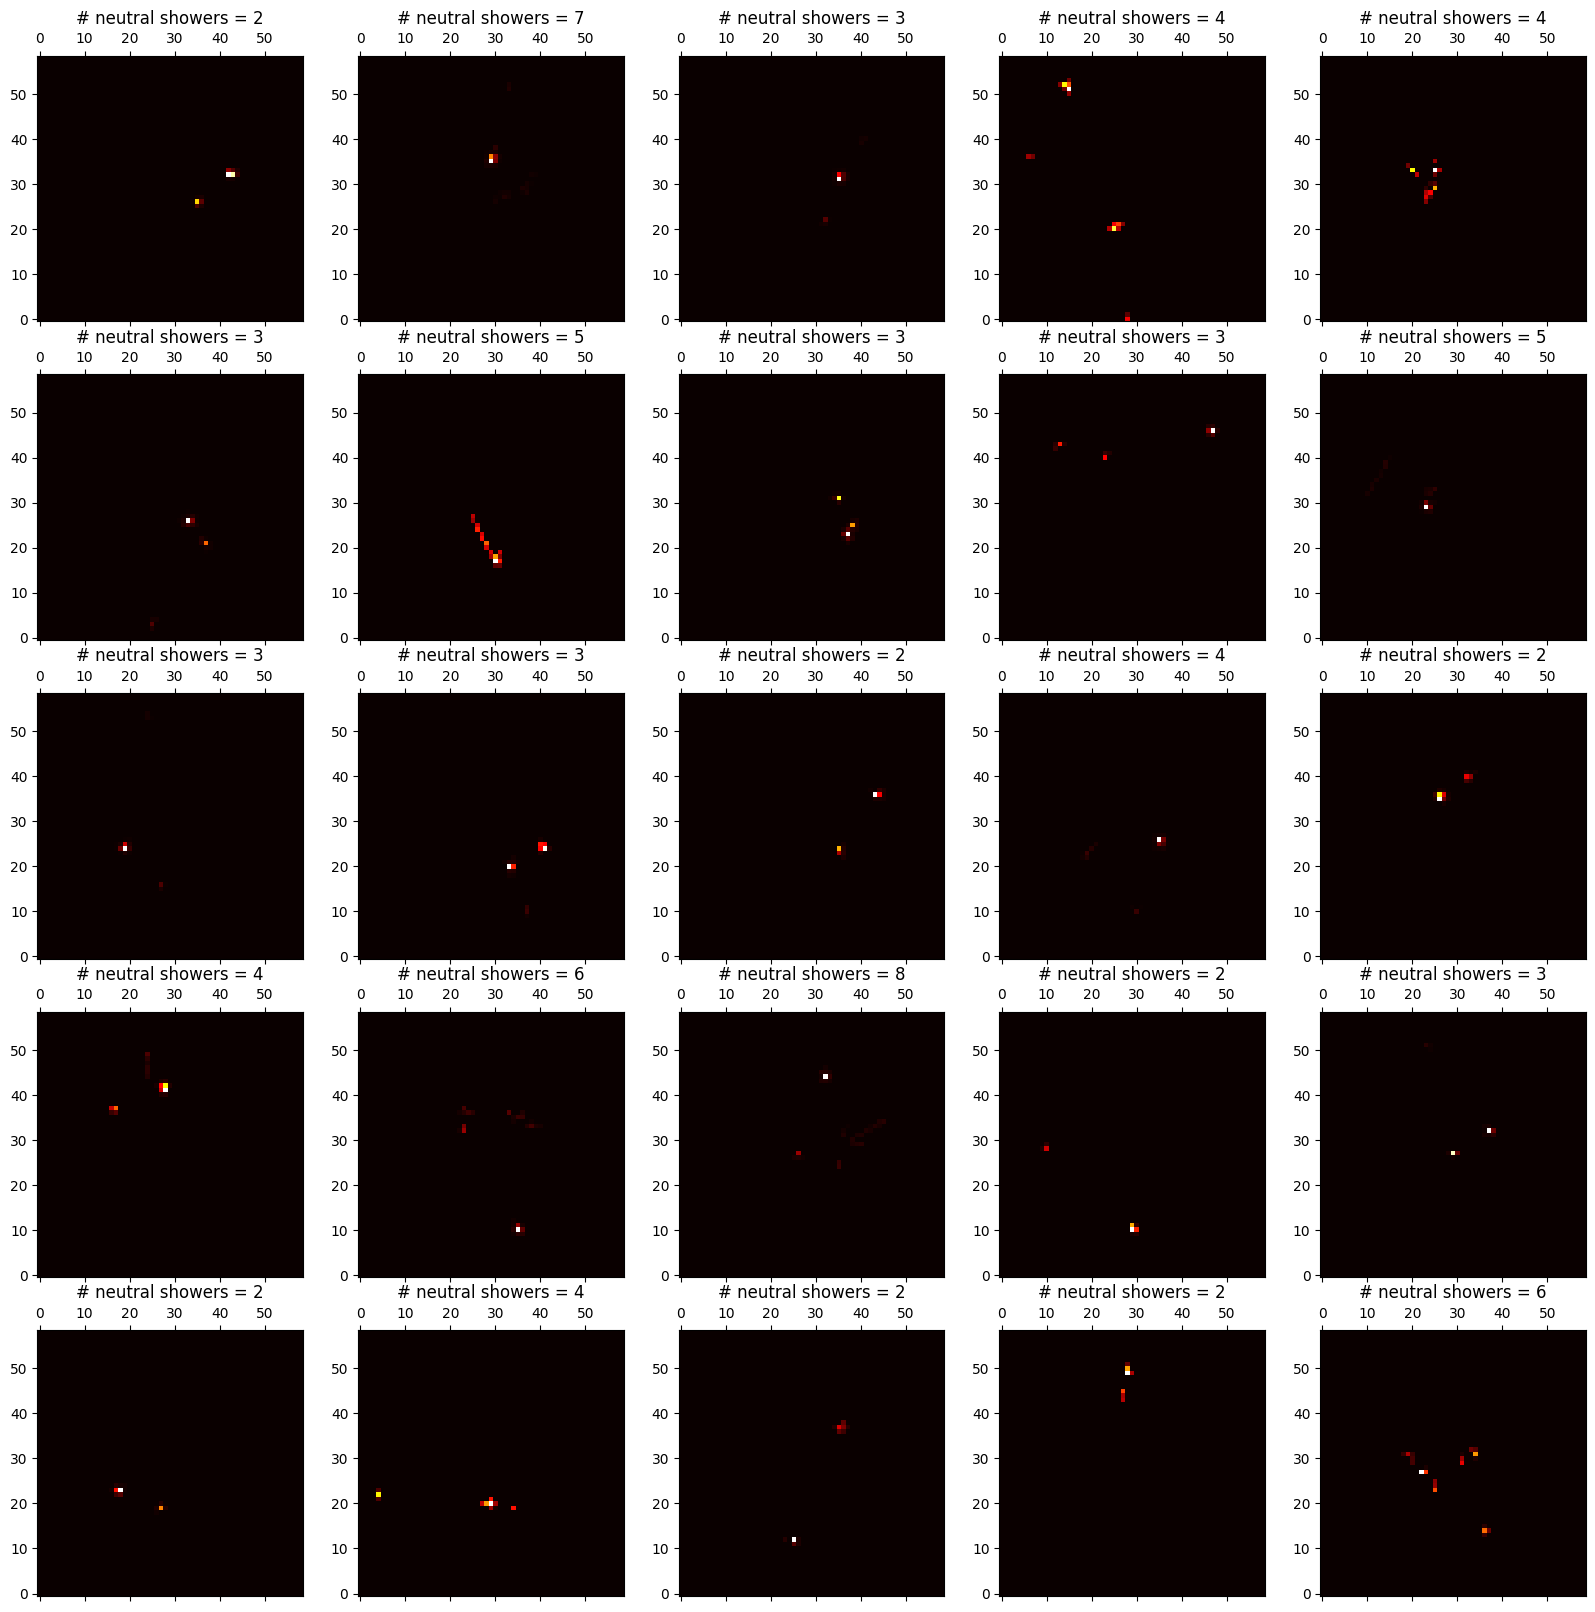

In [69]:
# lets go through events and makeShowerHitMaps

def MakeShowerHitMaps(event, FCAL_GEOM = (59, 59)) -> dict:
  nShowers = event.nShowers
  matrix_energies = np.zeros((nShowers, *FCAL_GEOM))
  FourVectors = []
  for i in range(nShowers):
    start_idx = event.startIndexPerShower[i]
    end_idx = start_idx + event.nHitsPerShower[i]
    matrix_energies[i, event.rows[start_idx:end_idx], event.cols[start_idx:end_idx]] = event.energies [start_idx:end_idx]
    # lets make a radius and center of shower to draw it.
    lorentzVector = vector.obj(
        px = event.FCALNeutralShowerPx[i],
        py = event.FCALNeutralShowerPy[i],
        pz = event.FCALNeutralShowerPz[i],
        E = event.FCALNeutralShowerE[i],
    )
    FourVectors.append(lorentzVector)
  return {"hitmap" : matrix_energies, "4vector" :  FourVectors}


def makeEvent(event, FCAL_GEOM = (59, 59)):
  hitMapDict = MakeShowerHitMaps(event, FCAL_GEOM)
  return np.sum(hitMapDict["hitmap"], axis = 0), event.nShowers

max_events = 25
events = {'hitmap': [], 'nShowers': []}
for idx, event in omega_df.iterrows():
  if idx >= max_events: break
  m, nshower = makeEvent(event)
  events['hitmap'].append(m)
  events['nShowers'].append(nshower)

fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (20, 20))
for i, ax in enumerate(axes.flatten()):
  ax.matshow(events['hitmap'][i], cmap='hot', origin = "lower")
  ax.set_title(f"# neutral showers = {events['nShowers'][i]}")
plt.show()

The objective here is to identify good photon like showers from these events and then use it to reconstruct the kinematics of $\pi^{0}$ and the $\omega$. For ease of use, Let us format the this information for event as

```bash
OmegaExclusive.h5
│
├── event_000001/
│   ├── piPlus_p4        → (4,)         [px, py, pz, E]
│   ├── piMinus_p4       → (4,)
│   ├── recoilProton_p4  → (4,)
│   ├── beam_p4          → (4,)
│   ├── nShowers         → (1,)
│   ├── shower_p4        → (nShowers, 4)
│   ├── shower_patches   → (nShowers, 11, 11)
│
├── event_000002/
│   ├── ...
│
└── metadata/
    ├── description      → "Omega Exclusive events with FCAL shower patches"
    ├── patch_shape      → (11, 11)
```

In [ ]:
import numpy as np

def make_event_patches(rows, cols, energies,
                       nHitsPerShower, startIndexPerShower,
                       patch_size=11):
    """
    Build (nShowers, patch_size, patch_size) patches for a single event.

    Parameters
    ----------
    rows, cols : 1D np.ndarray (int)
        Flattened FCAL hit coordinates for the event; hits are grouped
        contiguously per shower.
    energies : 1D np.ndarray (float)
        Flattened FCAL hit energies aligned with `rows`/`cols`.
    nHitsPerShower : 1D np.ndarray (int)
        Number of hits for each shower (length = nShowers).
    startIndexPerShower : 1D np.ndarray (int)
        Starting index in the flattened arrays for each shower (length = nShowers).
    patch_size : int, default=11
        Side length of the square patch to construct (e.g., 11 → 11x11).

    Returns
    -------
    patches : np.ndarray, shape = (nShowers, patch_size, patch_size), dtype=float32
        Energy patches centered on each shower’s max-energy hit.
    """
    # Basic checks
    assert rows.ndim == cols.ndim == energies.ndim == 1
    assert len(rows) == len(cols) == len(energies)
    nShowers = len(nHitsPerShower)
    assert len(startIndexPerShower) == nShowers

    half = patch_size // 2
    patches = np.zeros((nShowers, patch_size, patch_size), dtype=np.float32)

    # Build per-hit shower IDs: [0,0,...(nHits0 times), 1,1,...(nHits1 times), ...]
    shower_ids = np.repeat(np.arange(nShowers, dtype=np.int32), nHitsPerShower)

    # Find the max-energy hit (center) for each shower
    centers_r = np.empty(nShowers, dtype=np.int32)
    centers_c = np.empty(nShowers, dtype=np.int32)

    # Tiny loop over showers to locate the center index precisely
    for j in range(nShowers):
        start = int(startIndexPerShower[j])
        end = start + int(nHitsPerShower[j])
        if end <= start:  # empty shower guard (shouldn't happen, but be safe)
            centers_r[j] = 0
            centers_c[j] = 0
            print ("Warning: empty shower encountered.")
            continue
        local_energies = energies[start:end]
        local_argmax = np.argmax(local_energies)
        idx_max = start + local_argmax
        centers_r[j] = rows[idx_max]
        centers_c[j] = cols[idx_max]

    # Vectorized relative coordinates for all hits
    rel_r = rows - centers_r[shower_ids] + half
    rel_c = cols - centers_c[shower_ids] + half

    # Keep hits that fall inside the patch bounds
    valid = (
        (rel_r >= 0) & (rel_r < patch_size) &
        (rel_c >= 0) & (rel_c < patch_size)
    )

    # Accumulate energies into patches
    np.add.at(
        patches,
        (shower_ids[valid], rel_r[valid], rel_c[valid]),
        energies[valid].astype(np.float32)
    )

    return patches

# Test on first event
test_event = omega_df.iloc[1]
patches = make_event_patches(
    rows=test_event['rows'].to_numpy(),
    cols=test_event['cols'].to_numpy(),
    energies=test_event['energies'].to_numpy(),
    nHitsPerShower=test_event['nHitsPerShower'].to_numpy(),
    startIndexPerShower=test_event['startIndexPerShower'].to_numpy()
)
print(patches.shape)  # -> (nShowers, 11, 11)

(7, 11, 11)


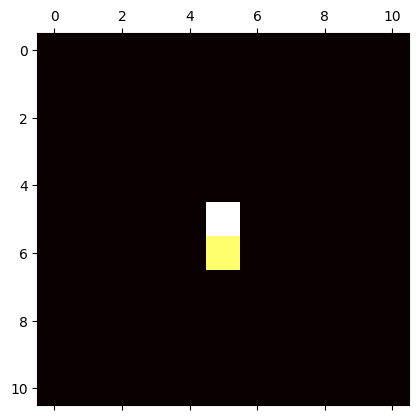

In [81]:
plt.matshow(patches[2], cmap='hot')